In [2]:
# Load up packages
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import xarray as xr
import pandas as pd
from sklearn.tree import  DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import sys
import pickle
import os
import warnings
from tqdm import tqdm
import cartopy.crs as ccrs
import xgboost as xgb
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})

sys.path.append('../..')
from src.models.ml_functions import  RF_regressor, plot_importances, XGBoost_regressor, Tu_label, XGBoost_regressor_tuned
from src.visualisation.visual_func import create_testdf, plot_std_lat, plot_residuals, stereo_plot
from src.models.corr_func import calc_correlation, plot_correlations, correlation_matrix
from src.models.learning_curve import learning_curve
from src.utils.directories import get_parent_directory
from src.models.encode_features import encode_tulabeldict
from src.models.corr_func import score_metrics, confidence_metrics

In [3]:
from src.models.encode_features import Tu_label

In [3]:
parent_dir = get_parent_directory()
parent_dir

'/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence'

In [4]:
# arctic_pkl = '/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/ml_ready/arctic2_1805.pkl'
arctic_pkl = (os.path.join(parent_dir, "data/processed/ml_ready/2706_time.pkl"))
arctic_df = pd.read_pickle(arctic_pkl)

In [5]:
def encode_tulabeldict(data):
    """
    Encodes the values in the 'Tu_label' column of a pandas DataFrame
    into numeric representations using a dictionary.

    Args:
        data (pandas.DataFrame): The input DataFrame containing a column
        named 'Tu_label'.

    Returns:
        pandas.DataFrame: The modified DataFrame with the 'Tu_label' column
        replaced by numeric labels.
        dict: Dictionary containing the label mappings.
    """
    # Create a dictionary to map labels to numeric representations
    label_map = {'NaN': 0,
                 'Diffusive Convection': 10,
                 'Doubly stable': 20,
                 'Salt fingering': 30,
                 'Statically unstable': 40}

    # Map the labels to their numeric representations
    numeric_labels = data['Tu_label'].map(label_map)

    # Replace the Tu_label column with the numeric labels
    data['Tu_label'] = numeric_labels

    return data, label_map


In [6]:
arctic_df, labels = encode_tulabeldict(arctic_df)

In [7]:
global_pkl = os.path.join(parent_dir, "data/processed/Mashayek2022/input_microstructure.pkl")
global_df = pd.read_pickle(global_pkl)
global_df = global_df.rename(columns={'lat': 'latitude', 'log_N2_sort': 'log_N2'})

## With SIC and MLD
700,000 datapoints

#### Filter out where depth is smaller than MLDJ (second derivative of potential density)

In [8]:
arctic_df["Tu_label"] = Tu_label(arctic_df["Tu"])
arctic_df, labels = encode_tulabeldict(arctic_df)

In [9]:
# MLDJ generates better results than MLDI, also according to literature and visual inspectation
MLD_df = arctic_df[arctic_df['depth'] >= arctic_df['MLDJ']]

# Convert 'inf' and '-inf' to 'NaN'
MLD_df = MLD_df.replace([np.inf, -np.inf], np.nan)

# Drop rows with 'NaN' values
MLD_df = MLD_df.dropna()

## Regularised regressor
Instead of using 

In [10]:
xgb_regularised = xgb.XGBRegressor(
    max_depth=3,
    n_estimators=700,
    learning_rate=0.01,  # Lower learning rate
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=0.1,  # L2 regularization
    random_state=42,
    subsample=0.5,
    gamma=0.1
)


In [11]:

def XGBoost_regressoryolo(dataframe, xfeatures, yfeatures, cv=False,
                      cruise_test=False, manual_regressor=None):
    """
    Perform XGBoost Regression on the given dataset.

    The function applies XGBoost regression to predict the target variable
    specified by yfeatures using the features specified by xfeatures.

    Parameters:
    - dataframe (pandas.DataFrame): The input dataset.
    - xfeatures (list): List of column names representing the input features.
    - yfeatures (list): List of column names representing the target variable.
    - cv (int or None): Number of cross-validation folds. If None,
        no cross-validation is performed.
    - cruise_test (bool or str): If bool, indicates whether to split the
        data into train and test sets randomly. If str, indicates the cruise
        name to use as the test set.
    - manual_regressor (xgboost.XGBRegressor): Optional manual XGBoost
        regressor object. If provided, this regressor will be used instead of
        creating a new one.

    Returns:
    - xgb_regressor (xgboost.XGBRegressor): The trained XGBoost regressor.
    - r2 (float): R2 score on the test set.
    - y_test (pandas.Series): The true values of the target variable for the
        test dataset.
    - y_pred (numpy.ndarray): The predicted values of the target variable for
        the test dataset.
    - X_test (pandas.DataFrame): The input features of the test dataset.
    - feature_importances (numpy.ndarray): The feature importances calculated
        by the XGBoost regressor.
    - X_train (pandas.DataFrame): The input features of the train dataset.
    - y_train (pandas.Series): The true values of the target variable for the
        train dataset.
    """

    if 'log_eps' not in dataframe.columns:
        dataframe['log_eps'] = dataframe['eps'].apply(lambda x: math.log(x))

    # Stop depth at 300m
    # dataframe = dataframe[dataframe["depth"] <= 300]

    SEED = 42

    if isinstance(cruise_test, str):
        # split test and train dataframe accordingly to test
        train_df = dataframe[dataframe["cruise"] != cruise_test]
        test_df = dataframe[dataframe["cruise"] == cruise_test]

        X_train = train_df[xfeatures]
        X_test = test_df[xfeatures]
        y_train = train_df[yfeatures]
        y_test = test_df[yfeatures]

    else:
        x = dataframe[xfeatures]
        y = dataframe[yfeatures]

        # Split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(x,
                                                            y,
                                                            test_size=0.2,
                                                            random_state=SEED)

    if manual_regressor is None:
        # Create the XGBoost regressor
        xgb_regressor = xgb.XGBRegressor(
            max_depth=7,
            n_estimators=300,
            learning_rate=0.1,
            random_state=SEED
        )
    else:
        xgb_regressor = manual_regressor

    # Fit the regressor on the training data
    xgb_regressor.fit(X_train, y_train)

    # Predict on the test set
    y_pred = xgb_regressor.predict(X_test)

    # Calculate R2 score
    r2 = r2_score(y_test, y_pred)

    # Perform cross-validation if cv is not None
    # cv = None
    if cv is not None:
        r2 = cross_val_score(xgb_regressor, X_train, y_train, cv=cv,
                             scoring='r2')

    # Plot feature importances
    feature_importances = xgb_regressor.feature_importances_
    sorted_indices = feature_importances.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_importances)),
             feature_importances[sorted_indices], align='center')
    plt.yticks(range(len(feature_importances)),
               [xfeatures[i] for i in sorted_indices])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('XGBoost Feature Importances')
    plt.show()

    return (xgb_regressor, r2, y_test, y_pred, X_test,
            feature_importances, X_train, y_train)


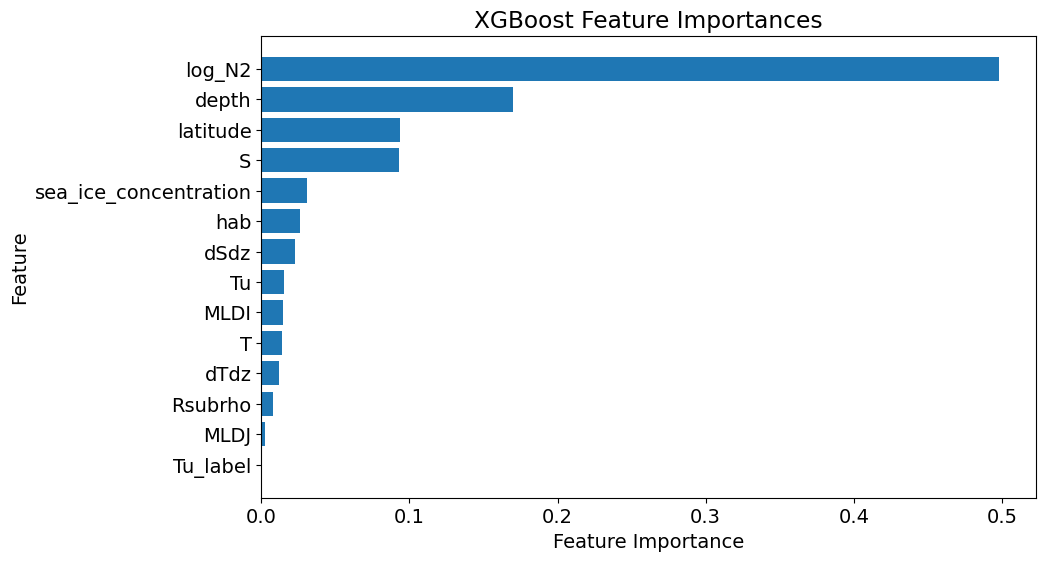

In [50]:
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude', 'Tu']

# We want to predict:
ystringlist_all_SIC = ['log_eps']

xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressoryolo(MLD_df, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised)

In [54]:
from sklearn.model_selection import learning_curve

# Define the XGBoost regressor model (xgb_regressor_all_SIC) and your data (X_train_SIC, y_train_SIC)
model = xgb_regressor_all_SIC

# Create the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_SIC, y_train_SIC, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of the train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score (R2)")
plt.grid()

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation Score")

plt.legend(loc="best")
plt.show()


In [14]:
r2_all_SIC

0.7237916129460371

R2 Score: 0.7134, 95% CI: [0.7086, 0.7181]
Mean Error (ME): 0.0101, 95% CI: [0.0079, 0.0122]
Mean Absolute Error (MAE): 0.2780, 95% CI: [0.2763, 0.2797]
Residual Standard Deviation: 0.4449, 95% CI: [0.4409, 0.4490]


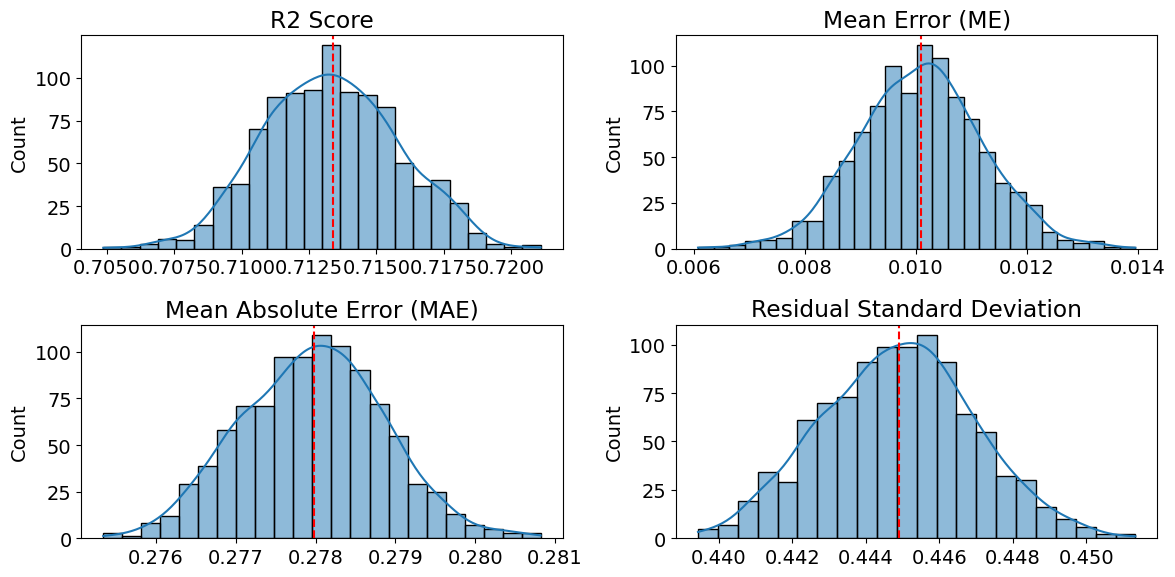

In [51]:
confidence_metrics(y_test_all_SIC, y_pred_all_SIC)

In [53]:
from pickle import dump, load

filename = os.path.join(parent_dir, "models/XGBoost/SIC_xgboostMLD.sav")
dump([xgb_regressor_all_SIC, X_train_SIC, X_test_all_SIC, y_train_SIC,y_test_all_SIC], open(filename, 'wb'))

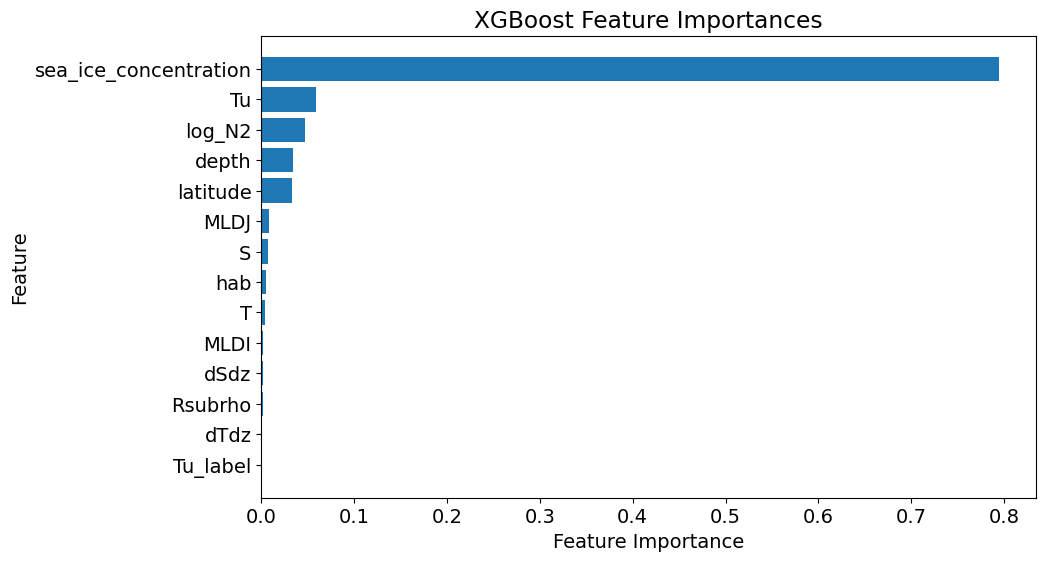

In [40]:
xgb_regressor_all_B2008, r2_all_B2008, y_test_all_B2008, y_pred_all_B2008, X_test_all_B2008, feature_importances_all_B2008, X_train_B2008, y_train_B2008 = XGBoost_regressor(MLD_df, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised, cruise_test="NICE-2015")

In [42]:
r2_all_B2008

-2.879690382633828

R2 Score: -3.1158, 95% CI: [-3.2283, -3.0111]
Mean Error (ME): -0.5325, 95% CI: [-0.5373, -0.5279]
Mean Absolute Error (MAE): 0.6573, 95% CI: [0.6534, 0.6612]
Residual Standard Deviation: 0.6974, 95% CI: [0.6922, 0.7023]


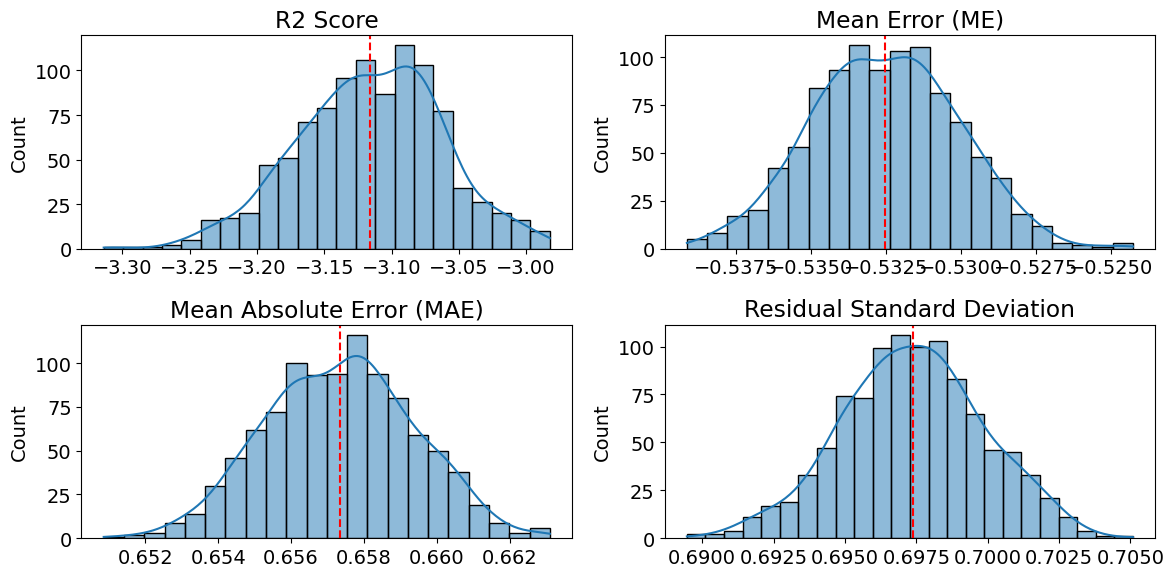

In [ ]:
confidence_metrics(y_test_all_B2008, y_pred_all_B2008)

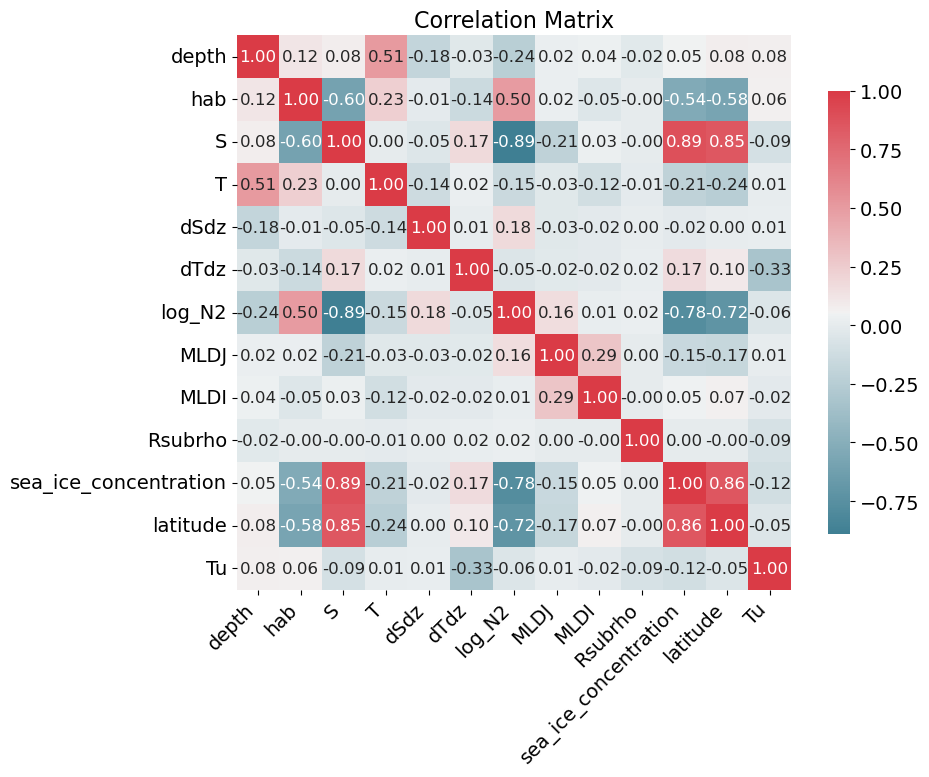

In [7]:
correlation_matrix(arctic_df, xstringlist_all_SIC)

r2_all_SIC is cross validation to get a better r2 score

In [ ]:
confidence_metrics()

## 7 features only

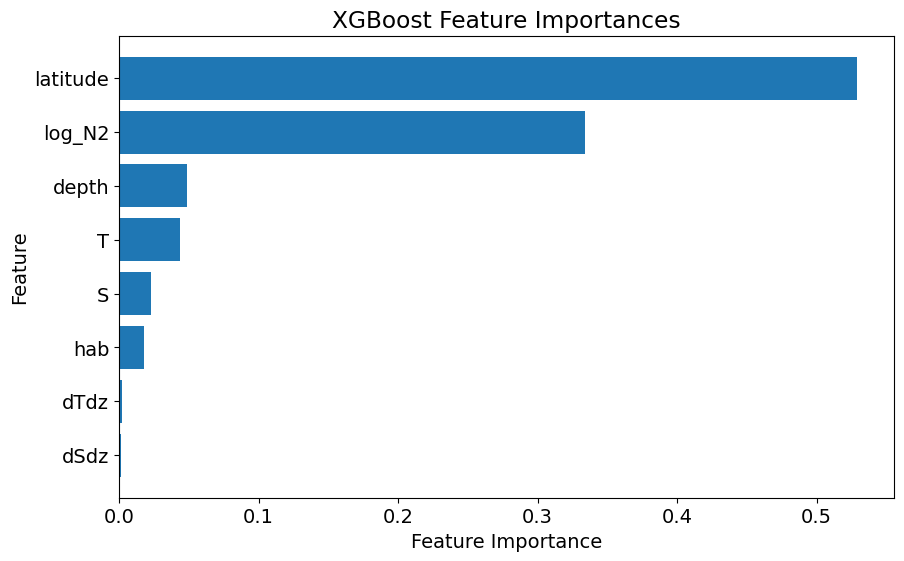

In [13]:
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'latitude']

# We want to predict:
ystringlist_all_SIC = ['log_eps']

xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(MLD_df, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised)

R2 Score: 0.9330, 95% CI: [0.9310, 0.9351]
Mean Error (ME): 0.0111, 95% CI: [0.0062, 0.0160]
Mean Absolute Error (MAE): 0.4640, 95% CI: [0.4594, 0.4683]
Residual Standard Deviation: 0.9778, 95% CI: [0.9620, 0.9926]


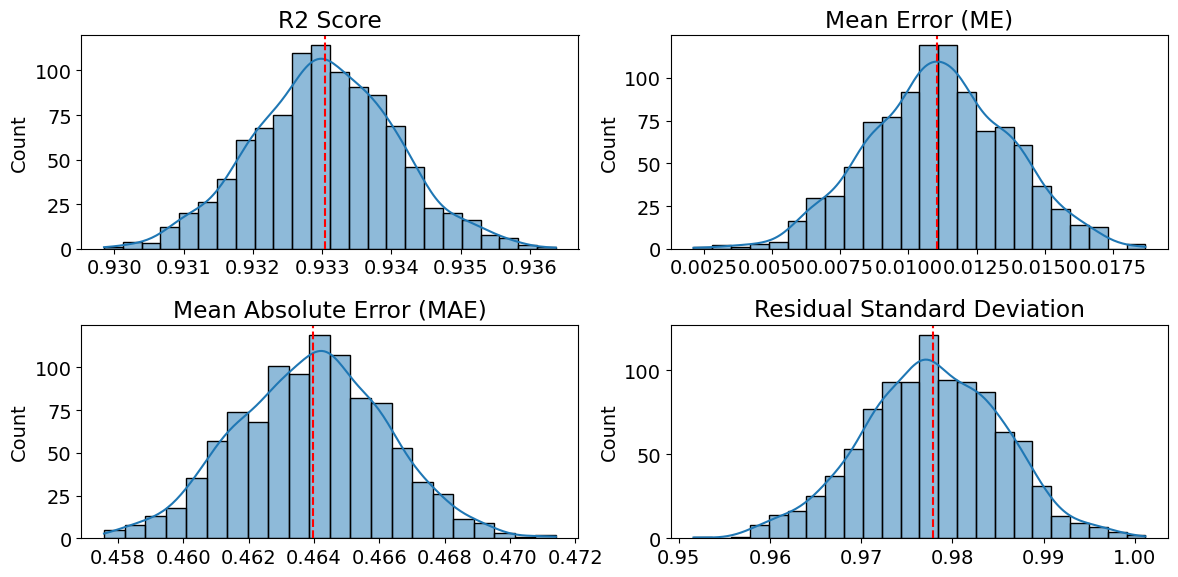

In [18]:
confidence_metrics(y_test_all_SIC, y_pred_all_SIC)

In [45]:
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=ystringlist_all_SIC)
# Rename the 'eps_pred' column to 'log_eps'
y_pred_df_SIC = y_pred_df_SIC.rename(columns={'log_eps': 'eps_pred'})

# Reset index on y_pred_df_SIC and y_test_df_SIC
y_pred_df_SIC.reset_index(drop=True, inplace=True)
y_test_all_SIC.reset_index(drop=True, inplace=True)
X_test_all_SIC.reset_index(drop=True, inplace=True)

# Create a new dataframe with index column
index_df_SIC = pd.DataFrame({'index': range(len(y_pred_df_SIC))})

# Merge y_pred_df_SIC and y_test_df_SIC on index_df_SIC
SIC_all_testdf = pd.concat([index_df_SIC, y_test_all_SIC, y_pred_df_SIC], axis=1)
SIC_all_testdf =  pd.concat([SIC_all_testdf, X_test_all_SIC], axis=1)

# Drop the 'index' column
SIC_all_testdf = SIC_all_testdf.drop('index', axis=1)

merged_df_SIC = SIC_all_testdf.merge(MLD_df, on=xstringlist_all_SIC+ystringlist_all_SIC)

merged_df_SIC = merged_df_SIC.drop_duplicates(subset=xstringlist_all_SIC+ystringlist_all_SIC)
residuals_SIC = (merged_df_SIC["log_eps"] - merged_df_SIC["eps_pred"])
merged_df_SIC["residuals"] = residuals_SIC 
merged_df_SIC["abs_residuals"] = residuals_SIC.abs()

In [ ]:
import matplotlib.pyplot as plt

# Calculate the mean predicted epsilon and confidence interval
mean_eps_pred = merged_df_SIC['eps_pred'].mean()
ci_lower = mean_eps_pred - me  # Lower bound of the confidence interval
ci_upper = mean_eps_pred + me  # Upper bound of the confidence interval

plt.plot(merged_df_SIC['eps_pred'], merged_df_SIC['depth'], label='Predicted Epsilon')
plt.fill_betweenx(merged_df_SIC['depth'], ci_lower, ci_upper, alpha=0.3, label='Confidence Interval')
plt.xlabel('Predicted Epsilon')
plt.ylabel('Depth')
plt.title('XGBoost: Averaged Predicted log_10 Epsilon Values for Test Dataset')
plt.grid(True)
plt.legend()

plt.gca().invert_yaxis()  # Invert the y-axis

plt.show()


In [36]:
filename = os.path.join(parent_dir, "models/XGboost/SIC_XG.sav")
from pickle import dump, load

filename = os.path.join(parent_dir, "models/XGBoost/SIC_xgboostMLD.sav")
dump([xgb_regressor_all_SIC, X_train_SIC, X_test_all_SIC, y_train_SIC,y_test_all_SIC], open(filename, 'wb'))

In [160]:
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=ystringlist_all_SIC)
# Rename the 'eps_pred' column to 'log_eps'
y_pred_df_SIC = y_pred_df_SIC.rename(columns={'log_eps': 'eps_pred'})

# Reset index on y_pred_df_SIC and y_test_df_SIC
y_pred_df_SIC.reset_index(drop=True, inplace=True)
y_test_all_SIC.reset_index(drop=True, inplace=True)
X_test_all_SIC.reset_index(drop=True, inplace=True)

# Create a new dataframe with index column
index_df_SIC = pd.DataFrame({'index': range(len(y_pred_df_SIC))})

SIC_all_testdf = create_testdf(X_test_all_SIC, y_test_all_SIC, y_pred_df_SIC)
merged_df_SIC = SIC_all_testdf.merge(MLD_df, on=["log_eps", "depth", "latitude"])

#merged_df_SIC = merged_df_SIC.drop_duplicates(subset=xstringlist_all+ystringlist)
residuals_SIC = (merged_df_SIC["log_eps"] - merged_df_SIC["eps_pred"])
#stereo_plot(merged_df_SIC, abs(residuals_SIC), "Absolute residuals")
# merged_df_SIC = SIC_all_testdf.merge(MLD_df, on=xstringlist_all+ystringlist)

: 

: 

## Evaluate residuals

In [158]:
# Calculate mean absolute residual per latitude
mean_residuals = merged_df_SIC.groupby('latitude')['residuals'].mean().abs()

# Plot mean absolute residual per latitude using a scatter plot
plt.scatter(mean_residuals.index, mean_residuals.values)
plt.xlabel('Latitude')
plt.ylabel('Mean Absolute Residual')
plt.title('Mean Absolute Residual vs. Latitude')
plt.show()

KeyError: 'Column not found: residuals'

In [13]:
# Sort the DataFrame by absolute residuals in descending order
merged_df_SIC_sorted = merged_df_SIC.sort_values(by='abs_residuals', key=lambda x: abs(x), ascending=False)

# Calculate the number of rows corresponding to the top 1% based on the DataFrame size
top_10_percent = int(len(merged_df_SIC_sorted) * 0.01)

# Extract the top 10% of residuals (on absolute terms)
top_residuals = merged_df_SIC_sorted.head(top_10_percent)

In [93]:
from scipy.stats import ttest_ind

# Iterate over each feature
for feature in arctic_df.columns:
    # Perform independent t-test
    t_stat, p_value = ttest_ind(arctic_df[feature], top_residuals[feature], equal_var=False)
    
    # Print the results
    print("Independent t-test for", feature)
    print("T-statistic:", t_stat)
    print("p-value:", p_value)
    print("\n")

Independent t-test for depth
T-statistic: -3.734451247579165
p-value: 0.0002008588244479289


Independent t-test for profile
T-statistic: 11.47420402435388
p-value: 2.066557923779111e-28




In [ ]:
learning_curve(xgb_regressor_all_SIC, X_train_SIC, y_train_SIC)

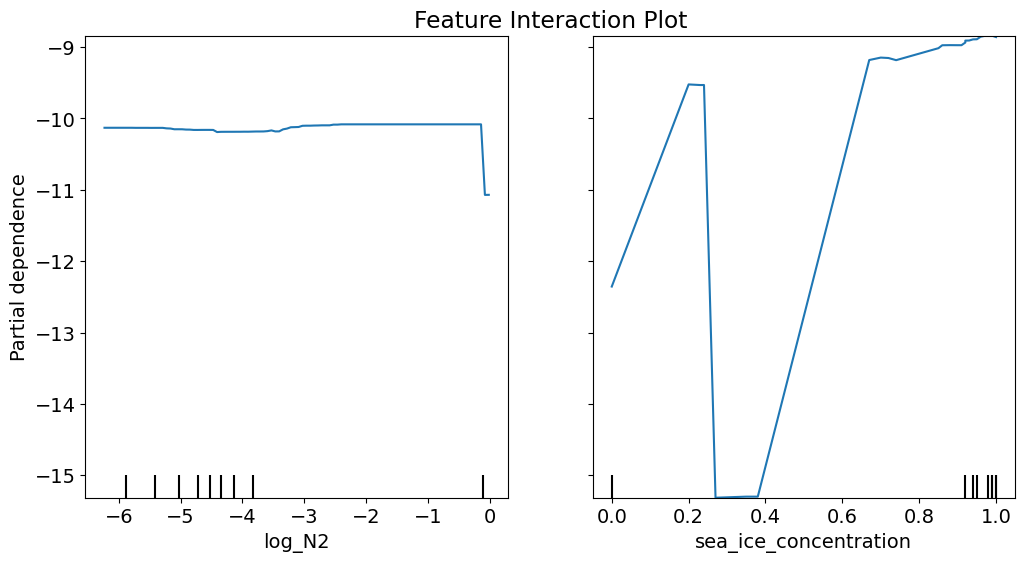

In [63]:
from sklearn.inspection import plot_partial_dependence

# Assuming you have trained a model called 'model' and have feature data in 'X'
# Select the features for the interaction plot
feature_indices = [6, 11]  # Indices of the selected features
features = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude', 'Tu']

# Create the feature interaction plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Feature Interaction Plot")
plot_partial_dependence(xgb_regressor_all_SIC,  arctic_df[features], feature_indices, ax=ax)

## Vary train and test

In [11]:
arctic_df.cruise.unique()

array(['NICE-2015', 'ArcticMix', 'Mosaic', 'Haakon Mosby', 'ABSO',
       'TEA_COSI', 'IPY Barneo 2007', 'IPY Barneo 2008',
       'Nansen Legacy 2018', 'Nansen Legacy 2019', 'ASCOS'], dtype=object)

In [1]:
xgb_regularised = xgb.XGBRegressor(
    max_depth=3,
    n_estimators=700,
    learning_rate=0.01,  # Lower learning rate
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=0.1,  # L2 regularization
    random_state=42,
    subsample=0.5,
    gamma=0.1
)


NameError: name 'xgb' is not defined

In [ ]:
## Barneo2008 7 features

## Barneo2008 7 features

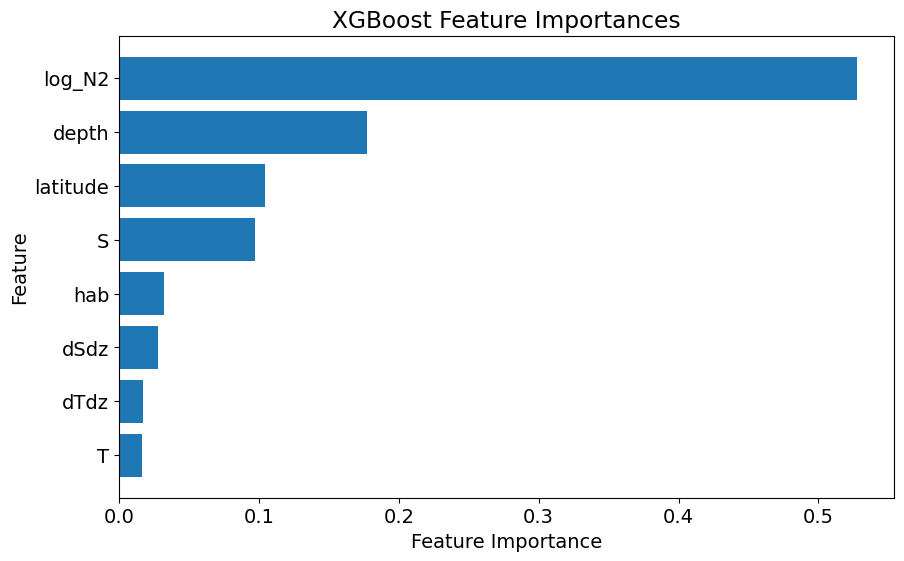

In [12]:
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'latitude']

# We want to predict:
ystringlist_all_SIC = ['log_eps']

xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(MLD_df, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised, cruise_test="IPY Barneo 2008")

In [13]:
# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred_all_SIC, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test_all_SIC, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(y_test_all_SIC, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

X_test_df_SIC['index'] = X_test_df_SIC.index
y_test_df_SIC['index'] = y_test_df_SIC.index
y_pred_df_SIC["index"] = y_pred_df_SIC.index

test_df = X_test_df_SIC.merge(y_test_df_SIC, on='index')
# Drop the index and create a new one
test_df['index'] = test_df.index
test_df = test_df.merge(y_pred_df_SIC, on='index')

# Specify the path and filename for the pickle file
pickle_path = os.path.join(parent_dir, "models/XGBoost/Barneo2008_7_testdf.pkl")
# Pickle the DataFrame
test_df.to_pickle(pickle_path)

In [14]:
confidence_metrics(y_test_all_SIC, y_pred_all_SIC)

: 

: 

## Barneo2008 7 features

In [1]:
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'latitude']

# We want to predict:
ystringlist_all_SIC = ['log_eps']

xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(MLD_df, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised, cruise_test="IPY Barneo 2008")

NameError: name 'XGBoost_regressor' is not defined

## Barneo2008

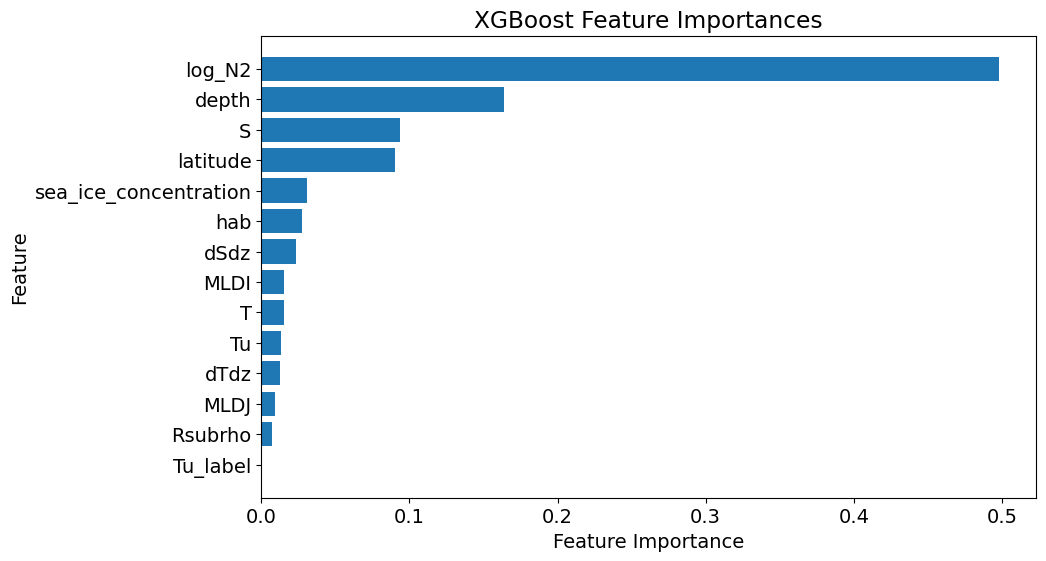

In [21]:
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude', 'Tu']

# We want to predict:
ystringlist_all_SIC = ['log_eps']

xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(MLD_df, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised, cruise_test="IPY Barneo 2008")

R2 Score: 0.2519, 95% CI: [0.2273, 0.2757]
Mean Error (ME): -0.0098, 95% CI: [-0.0127, -0.0070]
Mean Absolute Error (MAE): 0.2082, 95% CI: [0.2061, 0.2102]
Residual Standard Deviation: 0.3231, 95% CI: [0.3191, 0.3270]


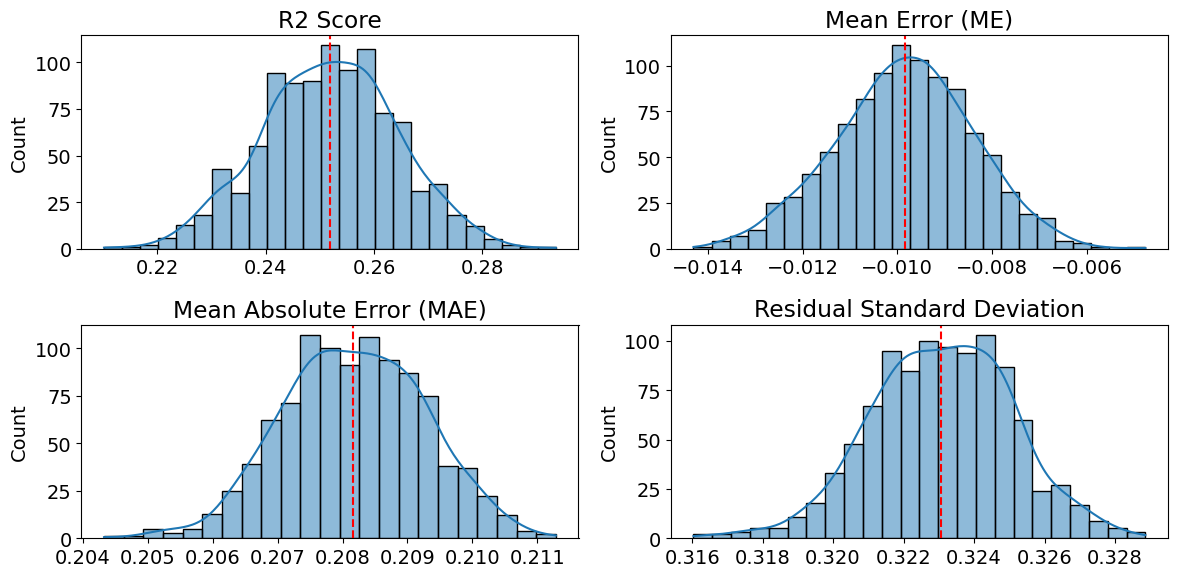

In [22]:
confidence_metrics(y_test_all_SIC, y_pred_all_SIC) 

In [23]:
# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred_all_SIC, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test_all_SIC, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(y_test_all_SIC, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

X_test_df_SIC['index'] = X_test_df_SIC.index
y_test_df_SIC['index'] = y_test_df_SIC.index
y_pred_df_SIC["index"] = y_pred_df_SIC.index

test_df = X_test_df_SIC.merge(y_test_df_SIC, on='index')
# Drop the index and create a new one
test_df['index'] = test_df.index
test_df = test_df.merge(y_pred_df_SIC, on='index')

# Specify the path and filename for the pickle file
pickle_path = os.path.join(parent_dir, "models/XGBoost/Barneo2008_testdf.pkl")
# Pickle the DataFrame
test_df.to_pickle(pickle_path)

#MLD_df['Tu_label'] = MLD_df['Tu_label'].astype(int)
#merged_df_SIC = test_df.merge(MLD_df, on=xstringlist_all_SIC)

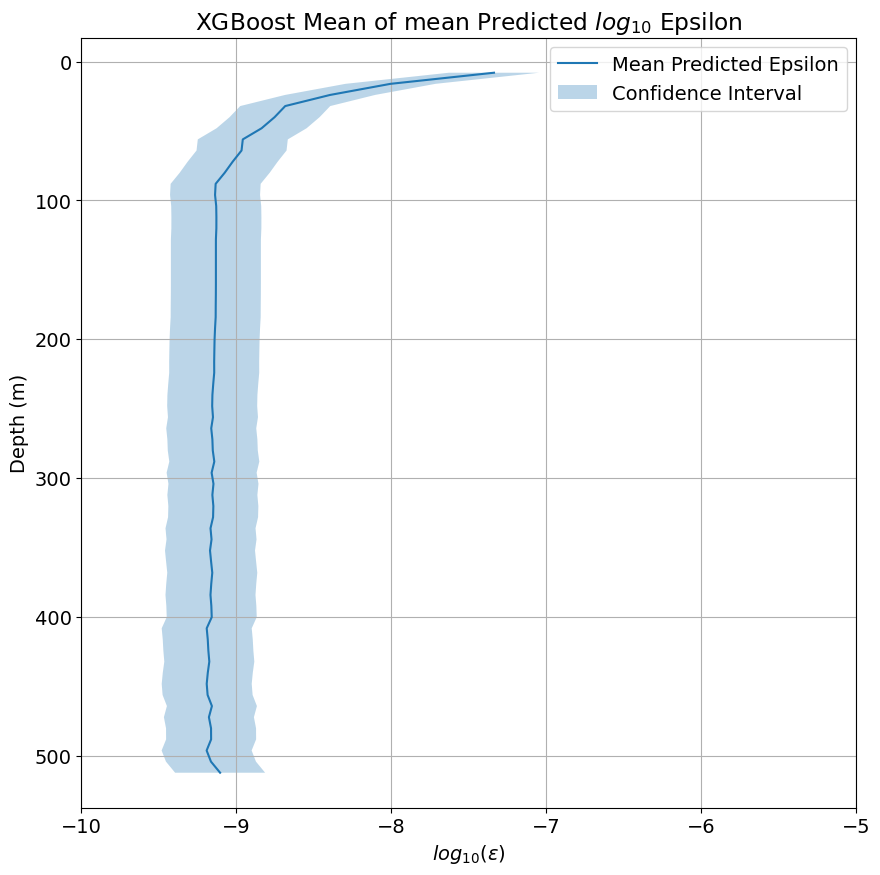

In [24]:
sorted_df = test_df.sort_values('depth')

# Sample every 10 meters
sampled_df = sorted_df[sorted_df['depth'] % 8 == 0]

# Group the data by depth and calculate the mean of epsilon predictions
mean_df = sampled_df.groupby('depth')['eps_pred'].mean().reset_index()

# Calculate the standard deviation
std_dev = mean_df['eps_pred'].std()

ci_lower = mean_df['eps_pred'] - std_dev  # Lower bound of the confidence interval
ci_upper = mean_df['eps_pred'] + std_dev  # Upper bound of the confidence interval

plt.plot(mean_df['eps_pred'], mean_df['depth'], label='Mean Predicted Epsilon')
plt.fill_betweenx(mean_df['depth'], ci_lower, ci_upper, alpha=0.3, label='Confidence Interval')
plt.xlabel('$log_{10}(\epsilon)$')
plt.ylabel('Depth (m)')
plt.title('XGBoost Mean of mean Predicted $log_{10}$ Epsilon')
plt.grid(True)
plt.legend()

# Set x-axis limits
plt.xlim(-10, -5)

plt.gca().invert_yaxis()  # Invert the y-axis

plt.show()


## TEA cosi

In [25]:
MLD_df.cruise.unique()

array(['NICE-2015', 'ArcticMix', 'Mosaic', 'Haakon Mosby', 'ABSO',
       'TEA_COSI', 'IPY Barneo 2007', 'IPY Barneo 2008',
       'Nansen Legacy 2018', 'Nansen Legacy 2019', 'ASCOS'], dtype=object)

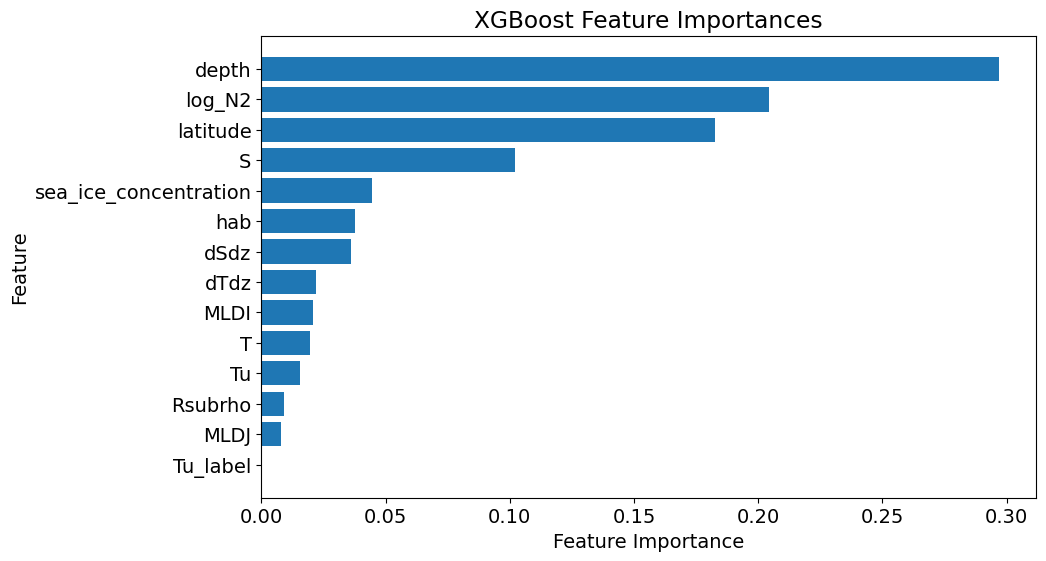

In [26]:
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude', 'Tu']

# We want to predict:
ystringlist_all_SIC = ['log_eps']

xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(MLD_df, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised, cruise_test="TEA_COSI")

In [27]:
r2_all_SIC

-7.8300765548330435

In [28]:
# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred_all_SIC, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test_all_SIC, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(y_test_all_SIC, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

X_test_df_SIC['index'] = X_test_df_SIC.index
y_test_df_SIC['index'] = y_test_df_SIC.index
y_pred_df_SIC["index"] = y_pred_df_SIC.index

test_df = X_test_df_SIC.merge(y_test_df_SIC, on='index')
# Drop the index and create a new one
test_df['index'] = test_df.index
test_df = test_df.merge(y_pred_df_SIC, on='index')

# Specify the path and filename for the pickle file
pickle_path = os.path.join(parent_dir, "models/XGBoost/TEA_COSI_testdf.pkl")
# Pickle the DataFrame
test_df.to_pickle(pickle_path)

#MLD_df['Tu_label'] = MLD_df['Tu_label'].astype(int)
#merged_df_SIC = test_df.merge(MLD_df, on=xstringlist_all_SIC)

In [29]:
from sklearn.metrics import r2_score, mean_absolute_error
# Calculate the original metrics
r2 = r2_score(y_test_all_SIC.values.flatten(), y_pred_all_SIC)
me = np.mean(y_pred_all_SIC - y_test_all_SIC.values.flatten())
mae = mean_absolute_error(y_test_all_SIC.values.flatten(), y_pred_all_SIC)
residuals = y_test_all_SIC.values.flatten() - y_pred_all_SIC
residual_std = np.std(residuals)

In [41]:
residual_std 

0.8087617761892906

# ArcticMix vary

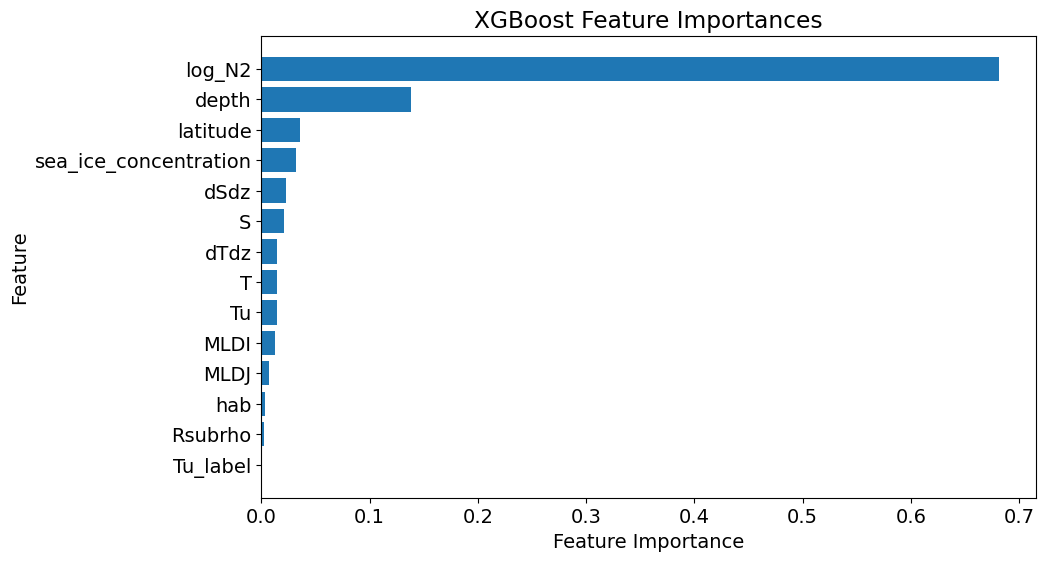

In [30]:
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude', 'Tu']

# We want to predict:
ystringlist_all_SIC = ['log_eps']

xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(MLD_df, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised, cruise_test="ArcticMix")

In [31]:
# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred_all_SIC, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test_all_SIC, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(y_test_all_SIC, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

X_test_df_SIC['index'] = X_test_df_SIC.index
y_test_df_SIC['index'] = y_test_df_SIC.index
y_pred_df_SIC["index"] = y_pred_df_SIC.index

test_df = X_test_df_SIC.merge(y_test_df_SIC, on='index')
# Drop the index and create a new one
test_df['index'] = test_df.index
test_df = test_df.merge(y_pred_df_SIC, on='index')

# Specify the path and filename for the pickle file
pickle_path = os.path.join(parent_dir, "models/XGBoost/ArcticMix_testdf.pkl")
# Pickle the DataFrame
test_df.to_pickle(pickle_path)

#MLD_df['Tu_label'] = MLD_df['Tu_label'].astype(int)
#merged_df_SIC = test_df.merge(MLD_df, on=xstringlist_all_SIC)

In [32]:
from sklearn.metrics import r2_score, mean_absolute_error
# Calculate the original metrics
r2 = r2_score(y_test_all_SIC.values.flatten(), y_pred_all_SIC)
me = np.mean(y_pred_all_SIC - y_test_all_SIC.values.flatten())
mae = mean_absolute_error(y_test_all_SIC.values.flatten(), y_pred_all_SIC)
residuals = y_test_all_SIC.values.flatten() - y_pred_all_SIC
residual_std = np.std(residuals)

: 

: 

## Nansen Legacy 2018

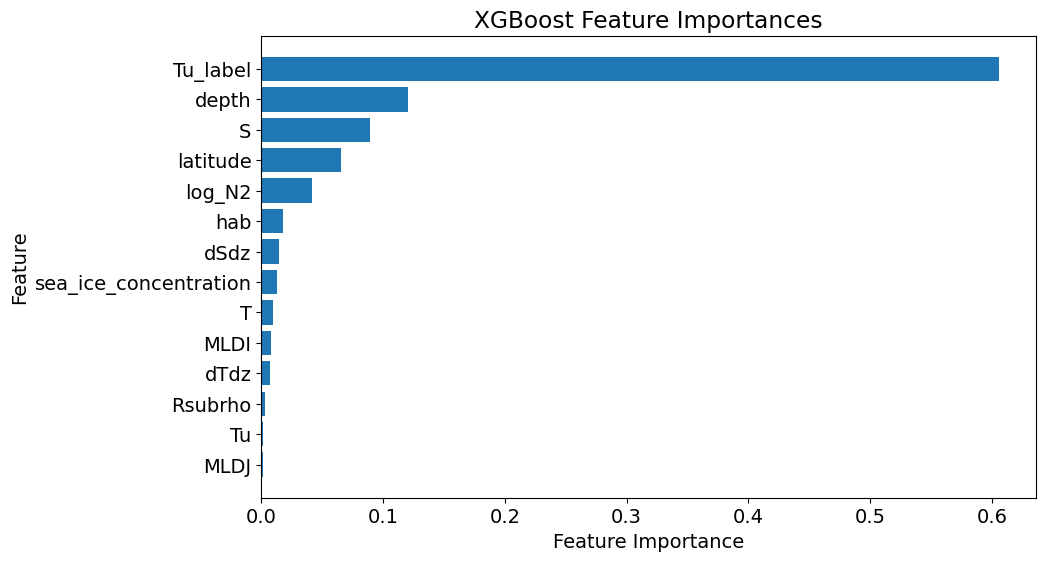

In [12]:
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude', 'Tu']

# We want to predict:
ystringlist_all_SIC = ['log_eps']

xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(MLD_df, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised, cruise_test="Nansen Legacy 2018")

In [13]:
from sklearn.metrics import r2_score, mean_absolute_error
# Calculate the original metrics
r2 = r2_score(y_test_all_SIC.values.flatten(), y_pred_all_SIC)
me = np.mean(y_pred_all_SIC - y_test_all_SIC.values.flatten())
mae = mean_absolute_error(y_test_all_SIC.values.flatten(), y_pred_all_SIC)
residuals = y_test_all_SIC.values.flatten() - y_pred_all_SIC
residual_std = np.std(residuals)

In [14]:
# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred_all_SIC, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test_all_SIC, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(y_test_all_SIC, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

X_test_df_SIC['index'] = X_test_df_SIC.index
y_test_df_SIC['index'] = y_test_df_SIC.index
y_pred_df_SIC["index"] = y_pred_df_SIC.index

test_df = X_test_df_SIC.merge(y_test_df_SIC, on='index')
# Drop the index and create a new one
test_df['index'] = test_df.index
test_df = test_df.merge(y_pred_df_SIC, on='index')

# Specify the path and filename for the pickle file
pickle_path = os.path.join(parent_dir, "models/XGBoost/Nansen2018_testdf.pkl")
# Pickle the DataFrame
test_df.to_pickle(pickle_path)

#MLD_df['Tu_label'] = MLD_df['Tu_label'].astype(int)
#merged_df_SIC = test_df.merge(MLD_df, on=xstringlist_all_SIC)

## Nansen 2019

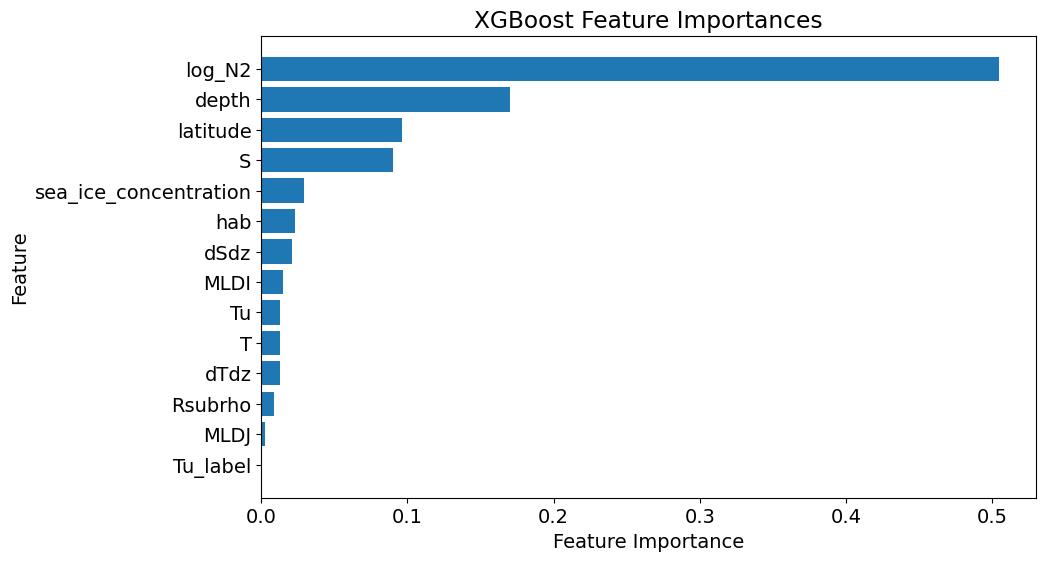

In [15]:
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude', 'Tu']

# We want to predict:
ystringlist_all_SIC = ['log_eps']

xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(MLD_df, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised, cruise_test="Nansen Legacy 2019")

# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred_all_SIC, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test_all_SIC, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(y_test_all_SIC, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

X_test_df_SIC['index'] = X_test_df_SIC.index
y_test_df_SIC['index'] = y_test_df_SIC.index
y_pred_df_SIC["index"] = y_pred_df_SIC.index

test_df = X_test_df_SIC.merge(y_test_df_SIC, on='index')
# Drop the index and create a new one
test_df['index'] = test_df.index
test_df = test_df.merge(y_pred_df_SIC, on='index')

# Specify the path and filename for the pickle file
pickle_path = os.path.join(parent_dir, "models/XGBoost/Nansen2019_testdf.pkl")
# Pickle the DataFrame
test_df.to_pickle(pickle_path)

#MLD_df['Tu_label'] = MLD_df['Tu_label'].astype(int)
#merged_df_SIC = test_df.merge(MLD_df, on=xstringlist_all_SIC)

## ASCOS

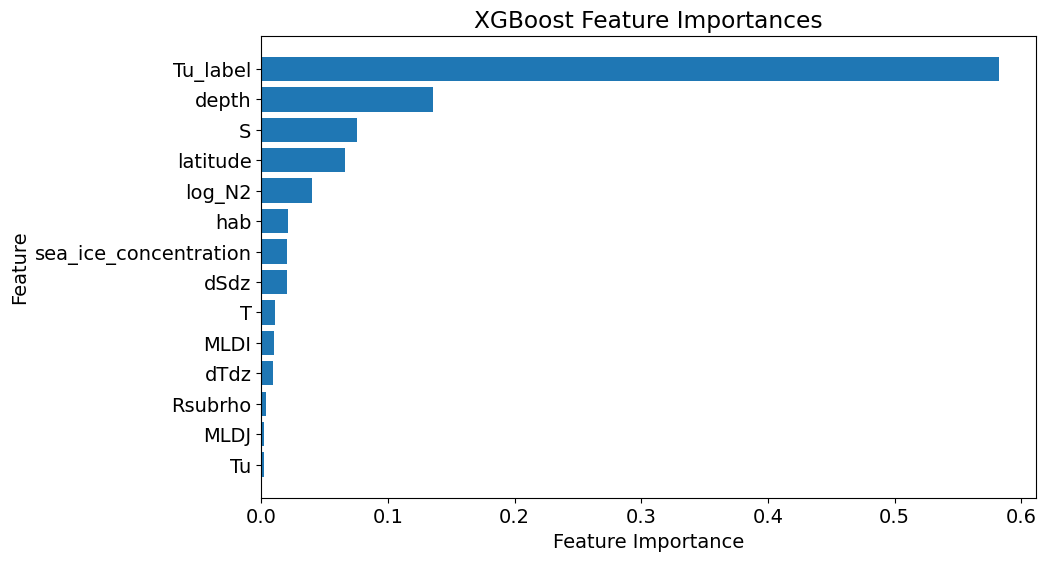

In [20]:
xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(MLD_df, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised, cruise_test="ASCOS")

# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred_all_SIC, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test_all_SIC, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(y_test_all_SIC, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

X_test_df_SIC['index'] = X_test_df_SIC.index
y_test_df_SIC['index'] = y_test_df_SIC.index
y_pred_df_SIC["index"] = y_pred_df_SIC.index

test_df = X_test_df_SIC.merge(y_test_df_SIC, on='index')
# Drop the index and create a new one
test_df['index'] = test_df.index
test_df = test_df.merge(y_pred_df_SIC, on='index')

# Specify the path and filename for the pickle file
pickle_path = os.path.join(parent_dir, "models/XGBoost/ASCOS_testdf.pkl")
# Pickle the DataFrame
test_df.to_pickle(pickle_path)

#MLD_df['Tu_label'] = MLD_df['Tu_label'].astype(int)
#merged_df_SIC = test_df.merge(MLD_df, on=xstringlist_all_SIC)

## ABSO

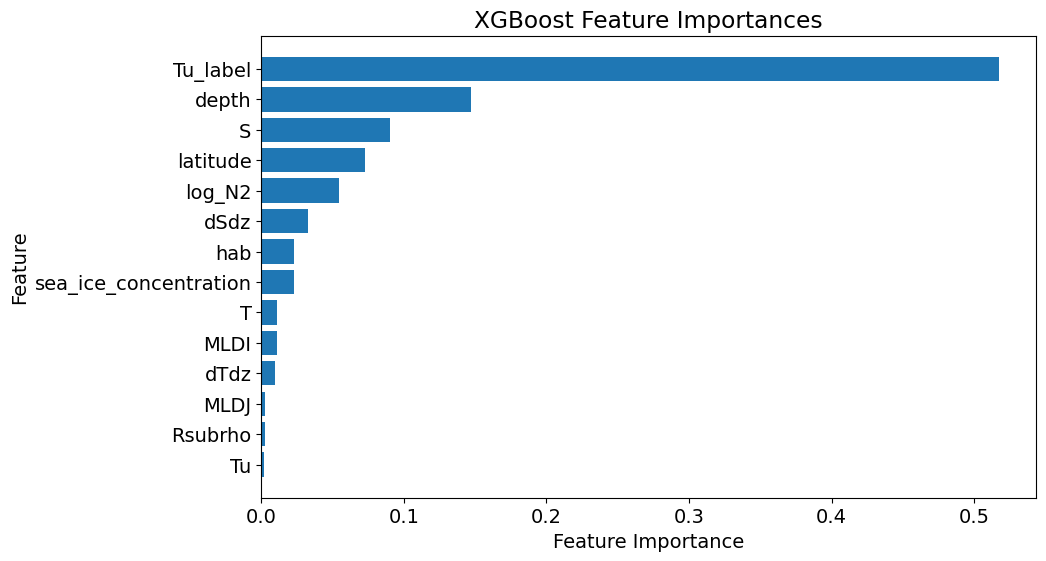

In [16]:
xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(MLD_df, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised, cruise_test="ABSO")

# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred_all_SIC, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test_all_SIC, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(y_test_all_SIC, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

X_test_df_SIC['index'] = X_test_df_SIC.index
y_test_df_SIC['index'] = y_test_df_SIC.index
y_pred_df_SIC["index"] = y_pred_df_SIC.index

test_df = X_test_df_SIC.merge(y_test_df_SIC, on='index')
# Drop the index and create a new one
test_df['index'] = test_df.index
test_df = test_df.merge(y_pred_df_SIC, on='index')

# Specify the path and filename for the pickle file
pickle_path = os.path.join(parent_dir, "models/XGBoost/ABSO_testdf.pkl")
# Pickle the DataFrame
test_df.to_pickle(pickle_path)

#MLD_df['Tu_label'] = MLD_df['Tu_label'].astype(int)
#merged_df_SIC = test_df.merge(MLD_df, on=xstringlist_all_SIC)

## Mosaic

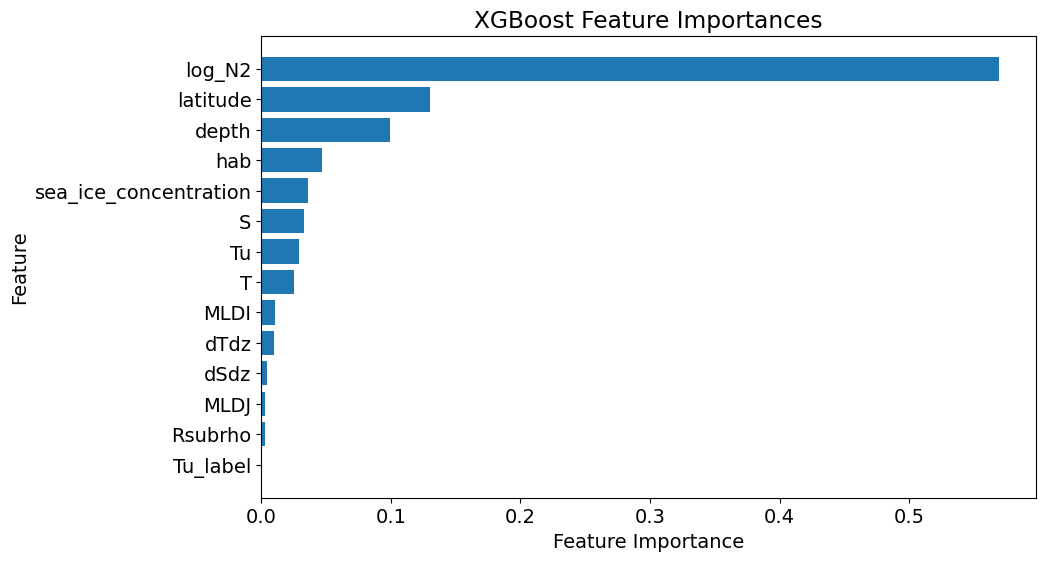

In [13]:
xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(MLD_df, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised, cruise_test="Mosaic")

# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred_all_SIC, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test_all_SIC, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(y_test_all_SIC, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

X_test_df_SIC['index'] = X_test_df_SIC.index
y_test_df_SIC['index'] = y_test_df_SIC.index
y_pred_df_SIC["index"] = y_pred_df_SIC.index

test_df = X_test_df_SIC.merge(y_test_df_SIC, on='index')
# Drop the index and create a new one
test_df['index'] = test_df.index
test_df = test_df.merge(y_pred_df_SIC, on='index')

# Specify the path and filename for the pickle file
pickle_path = os.path.join(parent_dir, "models/XGBoost/Mosaic_testdf.pkl")
# Pickle the DataFrame
test_df.to_pickle(pickle_path)

#MLD_df['Tu_label'] = MLD_df['Tu_label'].astype(int)
#merged_df_SIC = test_df.merge(MLD_df, on=xstringlist_all_SIC)

## NICE-2015

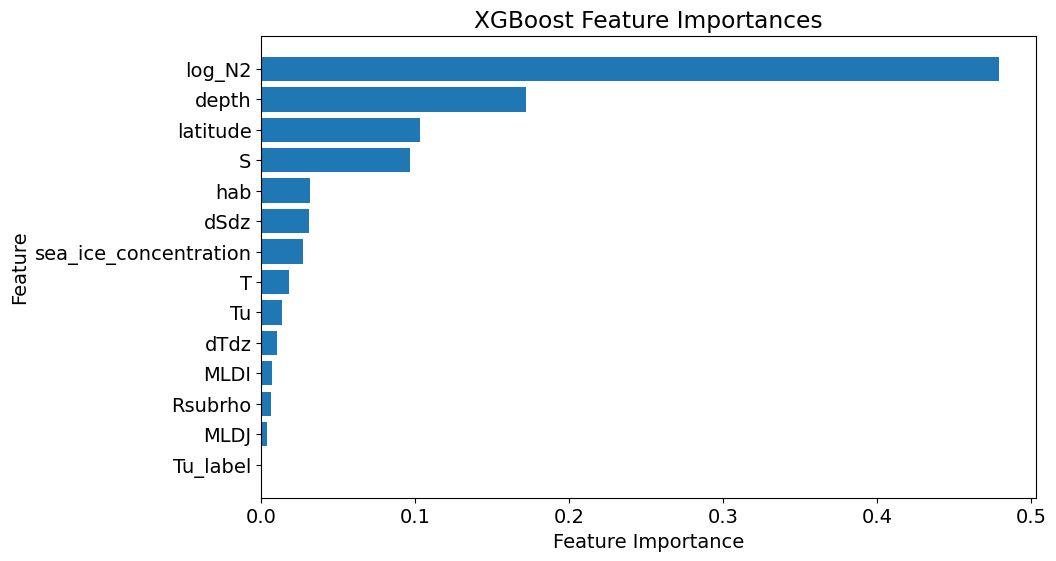

In [14]:
xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(MLD_df, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised, cruise_test="NICE-2015")

# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred_all_SIC, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test_all_SIC, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(y_test_all_SIC, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

X_test_df_SIC['index'] = X_test_df_SIC.index
y_test_df_SIC['index'] = y_test_df_SIC.index
y_pred_df_SIC["index"] = y_pred_df_SIC.index

test_df = X_test_df_SIC.merge(y_test_df_SIC, on='index')
# Drop the index and create a new one
test_df['index'] = test_df.index
test_df = test_df.merge(y_pred_df_SIC, on='index')

# Specify the path and filename for the pickle file
pickle_path = os.path.join(parent_dir, "models/XGBoost/NICE-2015_testdf.pkl")
# Pickle the DataFrame
test_df.to_pickle(pickle_path)

#MLD_df['Tu_label'] = MLD_df['Tu_label'].astype(int)
#merged_df_SIC = test_df.merge(MLD_df, on=xstringlist_all_SIC)

## Barneo 2007

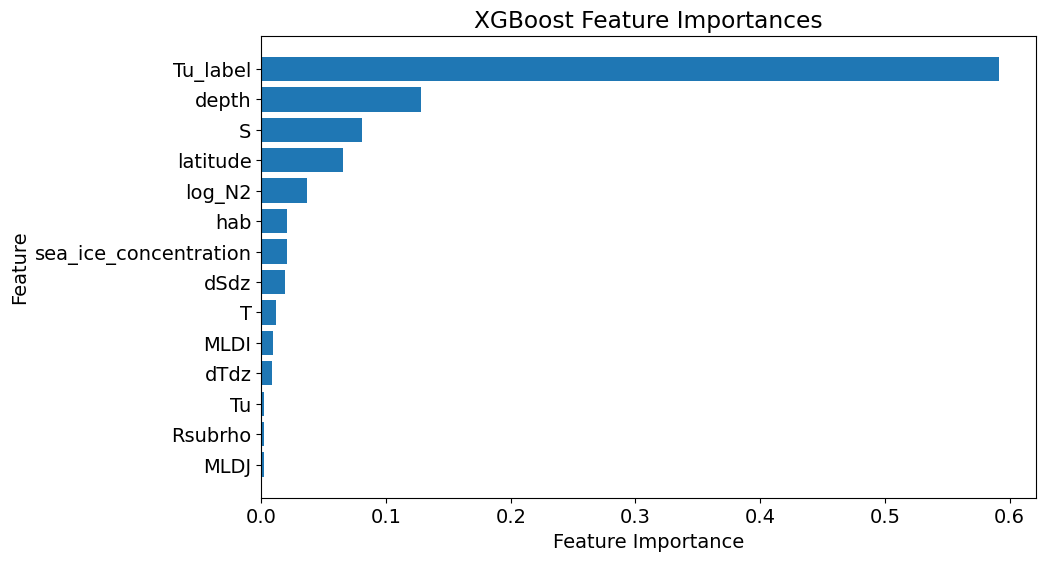

In [18]:
xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(MLD_df, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised, cruise_test="IPY Barneo 2007")

# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred_all_SIC, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test_all_SIC, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(y_test_all_SIC, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

X_test_df_SIC['index'] = X_test_df_SIC.index
y_test_df_SIC['index'] = y_test_df_SIC.index
y_pred_df_SIC["index"] = y_pred_df_SIC.index

test_df = X_test_df_SIC.merge(y_test_df_SIC, on='index')
# Drop the index and create a new one
test_df['index'] = test_df.index
test_df = test_df.merge(y_pred_df_SIC, on='index')

# Specify the path and filename for the pickle file
pickle_path = os.path.join(parent_dir, "models/XGBoost/Barneo2007_testdf.pkl")
# Pickle the DataFrame
test_df.to_pickle(pickle_path)

#MLD_df['Tu_label'] = MLD_df['Tu_label'].astype(int)
#merged_df_SIC = test_df.merge(MLD_df, on=xstringlist_all_SIC)

## Hyperparameter tuning

In [13]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

def XGBoost_regressor_tuning(dataframe, xfeatures, yfeatures):
    if "Tu_label" in xfeatures:
        hallo = Tu_label(dataframe.Tu)
        dataframe["Tu_label"] = hallo

        dataframe = encode_tulabel(dataframe)

    if 'log_eps' not in dataframe.columns:
        dataframe['log_eps'] = dataframe['eps'].apply(lambda x: math.log(x))

    # Stop depth at 300m
    # dataframe = dataframe[dataframe["depth"] <= 300]

    x = dataframe[xfeatures].values
    y = dataframe[yfeatures].values

    # Split into train and test sets
    SEED = 42
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

    # Define the parameter grid for grid search
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001]
    }

    # Define the XGBoost regressor
    xgb_regressor = xgb.XGBRegressor(random_state=SEED)

    # Perform grid search
    grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=3)
    grid_search.fit(X_train, y_train)

    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Predict on the test set using the best model
    y_pred = best_model.predict(X_test)

    # Calculate R2 score
    r2 = r2_score(y_test, y_pred)

    # Plot feature importances
    feature_importances = best_model.feature_importances_
    sorted_indices = feature_importances.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
    plt.yticks(range(len(feature_importances)), [xfeatures[i] for i in sorted_indices])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('XGBoost Feature Importances')
    plt.show()

    return best_model, r2, y_test, y_pred, X_test, feature_importances, best_params


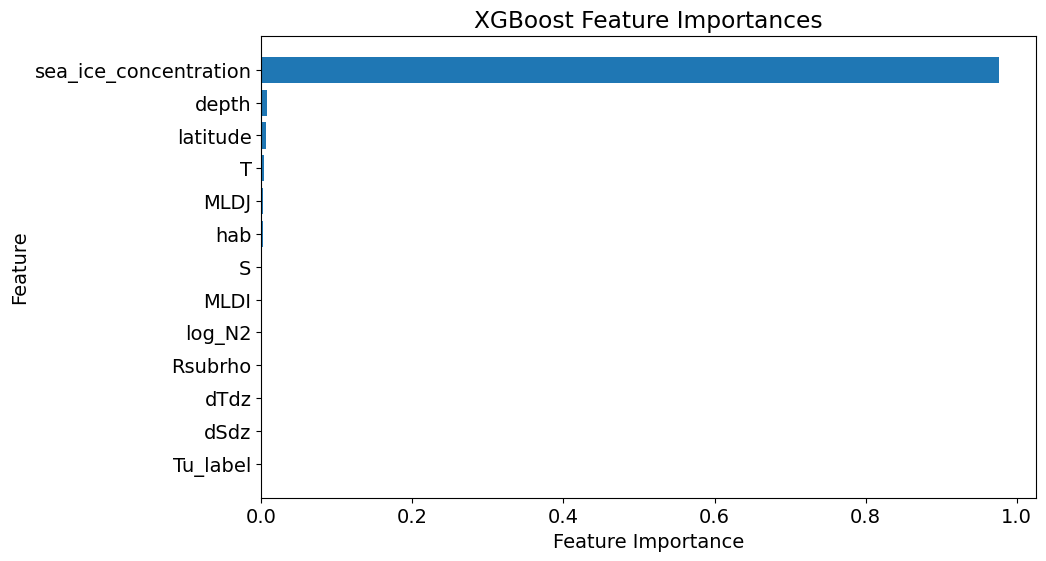

In [24]:
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude']

# We want to predict:
ystringlist_all_SIC = ['log_eps']

best_model, r2_tune, y_test_tune, y_pred_tune, X_test_tune, feature_importances_tune, best_params  =  XGBoost_regressor_tuning(MLD_df, xstringlist_all_SIC, ystringlist_all_SIC)

In [25]:
best_model_params = best_model.get_params()
print(best_model_params)

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [30]:
import joblib

# Save the parameters
joblib.dump(best_model, 'XGboost/best_model.sav')
joblib.dump(r2_tune, 'XGboost/r2_tune.sav')
joblib.dump(y_test_tune, 'XGboost/y_test_tune.sav')
joblib.dump(y_pred_tune, 'XGboost/y_pred_tune.sav')
joblib.dump(X_test_tune, 'XGboost/X_test_tune.sav')
joblib.dump(feature_importances_tune, 'XGboost/feature_importances_tune.sav')
joblib.dump(best_params, 'XGboost/best_params.sav')

['XGboost/best_params.sav']

best_model = joblib.load('best_model.sav')
r2_tune = joblib.load('r2_tune.sav')
y_test_tune = joblib.load('y_test_tune.sav')
y_pred_tune = joblib.load('y_pred_tune.sav')
X_test_tune = joblib.load('X_test_tune.sav')
feature_importances_tune = joblib.load('feature_importances_tune.sav')
best_params = joblib.load('best_params.sav')

In [ ]:
filename = "SIC_xgboost.sav"

dump([xgb_regressor_all_SIC, X_train_SIC, X_test_all_SIC, y_train_SIC,y_test_all_SIC], open(filename, 'wb'))